In [1]:
# Reference: https://stackoverflow.com/questions/15514593/importerror-no-module-named-when-trying-to-run-python-script/15622021#15622021
import sys
sys.path.append(r'G:\Grid_Orientation\LISFLOOD_FP\Modelling\Modules')

In [2]:
import numpy as np

import geopandas as gpd                             # For polygon manipulation
import pdal                                         # For LiDAR manipulation
import json                                         # For instruction manipulation
from scipy import interpolate                       # For interpolation

import rioxarray                                    # For raster manipulation
import xarray                                       # For raster manipulation

from transformation import read_las_file

# Crop function

In [3]:
def crop_lidar(shape_file, file_to_crop, file_being_cropped, inside=True):
    """This function is to crop LiDAR based on polygon. The results could be LiDAR outside or inside polygon

    -----------
    References:
                None.
    -----------

    -----------
    Arguments:
                shape_file:
                (string)
                                        The directory to polygon file
                file_to_crop:
                (string)
                                        The directory to the file that will be cropped
                file_being_cropped:
                (string)
                                        The directory to the cropped file
                inside:
                (boolean)
                                        True - remove all LiDAR outside
                                        False - remove all LiDAR inside
    -----------

    -----------
    Returns:
                None.
    -----------

    """
    # Get polygon figures
    polygon = gpd.read_file(shape_file)
    polygon_wkt = polygon['geometry'].to_wkt()

    # Develop cropping instruction
    if inside:
        instruction_crop = [
            file_to_crop,
            {
                "type": "filters.crop",
                "polygon": polygon_wkt[0],
                "distance": 0,
                "outside": False
            },
            {
                "type": "writers.las",
                "filename": file_being_cropped,
                "compression": "laszip"
            }
        ]
    else:
        instruction_crop = [
            file_to_crop,
            {
                "type": "filters.crop",
                "polygon": polygon_wkt[0],
                "distance": 0,
                "outside": True
            },
            {
                "type": "writers.las",
                "scale_x": 0.0001,
                "scale_y": 0.0001,
                "offset_x": 1700000,
                "offset_y": 5400000,
                "filename": file_being_cropped,
                "compression": "laszip"
            }
        ]

    pipeline_crop = pdal.Pipeline(json.dumps(instruction_crop))
    pipeline_crop.execute()

# Write into las/laz file

In [15]:
def writing_las_file(data_array_func):
    """This function is to create a new lidar las/laz file
    the same as the old lidar las/laz file with different coordinates

    -----------
    References: https://pdal.io/tutorial/las.html
    -----------

    -----------
    Arguments:
                data_array_func:
                (array)
                                            Array of raster

    -----------

    -----------
    Returns:
                None.
    -----------
    """
    # Set up horizontal and vertical crs
    h_crs = 2193
    v_crs = 7839

    # Get the shape of transformed LiDAR array
    lidar_arr_shape = data_array_func.shape[0]

    # Create empty transformed LiDAR array
    lidar_arr = np.empty([lidar_arr_shape], dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Classification', 'u1')])

    # Overwrite the X, Y, and Z values in the points array with the transformed values
    lidar_arr['X'] = (data_array_func[:, 0]).flatten()
    lidar_arr['Y'] = (data_array_func[:, 1]).flatten()
    lidar_arr['Z'] = (data_array_func[:, 2]).flatten()
    lidar_arr['Classification'] = np.array([2] * lidar_arr_shape)

    # Save the file
    pdal_pipeline_instructions = [
        {
            "type": "writers.las",
            "scale_x": 'auto',
            "scale_y": 'auto',
            "offset_x": 'auto',
            "offset_y": 'auto',
            "a_srs": f"EPSG:{h_crs}+{v_crs}",
            "filename": r"S:\Lidar_example\lidar_river_1m.laz",
            "compression": "laszip"
        }
    ]

    # Run
    pdal_pipeline = pdal.Pipeline(json.dumps(pdal_pipeline_instructions), [lidar_arr])
    pdal_pipeline.execute()


# Read raster

In [19]:
def array_creation(data_array, value):
    """This function is to create an array of a coordinate

    -----------
    References:
                None.
    -----------

    -----------
    Arguments:
                data_array:
                (array)
                                        Original array with full data
                value:
                (string)
                                        The value of original array need extracting.
                                        Two main choices - 'x' or 'y'
    -----------

    -----------
    Returns:
                new_array:
                (array)
                                        New clipped array
    -----------
    """
    # Read x, y values into arrays
    arr_x = data_array.x.values
    arr_y = data_array.y.values
    
    # Create zero array
    new_array = np.zeros((arr_y.shape[0], arr_x.shape[0]))
    

    # Get full number of x or y values
    if value == "x":
        
        
        for i in range(arr_x.shape[0]):
            for j in range(arr_y.shape[0]):
                new_array[j, i] = arr_x[i]
        return new_array
        

    else:
        
        for i in range(arr_x.shape[0]):
            for j in range(arr_y.shape[0]):
                new_array[j, i] = arr_y[j]
        return new_array
    
    
        

In [6]:
example_raster = rioxarray.open_rasterio(r"S:\LISFLOOD\version_1\3_dem_raster\combined_dem_raster\com_dem_raster\com_netcdf\generated_dem_no_padding.nc")
example_raster

<xarray.DataArray 'idw' (band: 1, y: 160, x: 320)>
array([[[ 6.115206,  5.73924 , ..., 16.298257, 16.64955 ],
        [ 5.75129 ,  5.753206, ..., 16.286686, 16.501688],
        ...,
        [ 6.973576,  7.133303, ..., 24.14    , 24.607887],
        [ 7.132378,  7.820315, ..., 24.529687, 24.668054]]])
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 1.77e+06 1.77e+06 1.77e+06 ... 1.773e+06 1.773e+06
  * y            (y) float64 5.473e+06 5.473e+06 ... 5.472e+06 5.472e+06
    spatial_ref  int32 0
Attributes:
    add_offset:          0.0
    long_name:           idw
    scale_factor:        1.0
    STATISTICS_MAXIMUM:  41.349570318575
    STATISTICS_MEAN:     9.5495874020797
    STATISTICS_MINIMUM:  0.20758818569603
    STATISTICS_STDDEV:   5.5448378149633
    _FillValue:          nan

In [7]:
arr_x = array_creation(example_raster, "x")

In [8]:
arr_x.shape

(160, 320)

In [9]:
arr_y = array_creation(example_raster, "y")
arr_y.shape

(160, 320)

In [10]:
def xyz_array(data_array_func):
    """This function is to create an array from flowdepth raster including x, y, z values

    -----------
    References:
                None.
    -----------

    -----------
    Arguments:
                data_array_func:
                (array)
                                            Array of raster
    -----------

    -----------
    Returns:
                full_dataset:
                (array)
                                            A dataset contains 1D x, y, z array including padding
    -----------
    """

    # Create full number of values of x, y, z coordinates
    array_x = array_creation(data_array_func, 'x')
    array_y = array_creation(data_array_func, 'y')
    array_z = data_array_func.values

    # Flatten x, y, z arrays
    flatten_x = array_x.flatten()
    print(flatten_x)
    flatten_y = array_y.flatten()
    print(flatten_y)
    flatten_z = array_z.flatten()
    print(flatten_z)

    # Put all x, y, z into one array
    full_dataset = np.vstack((flatten_x, flatten_y, flatten_z)).transpose()

    return full_dataset

# New interpolation

In [11]:
def new_interpolation_data(data_array_func):
    """This function is to create new interpolated data by replace all current z values with new z values
    from 2D interpolation

    -----------
    References:
                None.
    -----------

    -----------
    Arguments:
                data_array_func:
                (array)
                                            Array of raster
    -----------

    -----------
    Returns:
                full_dataset:
                (array)
                                            A dataset contains 1D x, y, z array including padding
    -----------
    """

    # Make an array copy
    copy_full_data = data_array_func.copy()

    # Loop to replace current z values with new z values
    for i in range(data_array_func.shape[0]):
        copy_full_data[i, 2] = f(data_array_func[i, 0], data_array_func[i, 1])

    return copy_full_data

-------------------------------------------------------------------------------------------------------------------------------

# River raster 1m resolution

In [ ]:
crop_lidar(
    r"S:\\Lidar_example\\waikanae_part8.shp",
    r"S:\Lidar_example\points.laz",
    r"S:\Lidar_example\cropped_river_waikanae.laz",
    inside=True
)


# Interpolate at 1m resolution
instruction_interpolation = [
    r"S:\Lidar_example\cropped_river_waikanae.laz",
    {
        "type": "writers.gdal",
        "filename": r"S:\Lidar_example\river_raster.nc",
        "nodata": 0,
        "data_type": "float64",
        "output_type": "mean",
        "resolution": 1
    }
]

pipeline_interpolation = pdal.Pipeline(json.dumps(instruction_interpolation))
pipeline_interpolation.execute()

# Read raster and fill na
raster_river = rioxarray.open_rasterio(r"S:\Lidar_example\river_raster.nc")
new_raster_river = raster_river.rio.interpolate_na()

# Write filled raster into new raster
new_raster_river.rio.to_raster(r"S:\Lidar_example\waikanae_river_filled.nc")

# Crop river and convert into LIDAR

In [17]:
# Read raster of nodata-filled full waikanae river
filled_raster_river = rioxarray.open_rasterio(r"S:\Lidar_example\waikanae_river_filled.nc")

# Convert into 3D array (x, y, z)
full_data = xyz_array(filled_raster_river)

# Convert into LiDAR
writing_las_file(full_data)

# Crop only river
crop_lidar(
    r"S:\\Lidar_example\\waikanae_part8.shp",
    r"S:\Lidar_example\lidar_river_1m.laz",
    r"S:\Lidar_example\river_1m_crop2.laz",
    inside=True
)

# Read the 1m resolution LiDAR that is just cropped
point_1m_class, point_1m_coord = read_las_file(r"S:\Lidar_example\river_1m_crop2.laz")

# Function for 2D interpolation with cubic

In [21]:
# # Crop some parts of LiDAR for developing interpolation function
# crop_lidar(
#     fr"S:\Lidar_example\crop_before_1.shp",
#     fr"S:\Lidar_example\cropped_river_waikanae.laz",
#     fr"S:\Lidar_example\crop_before.laz",
#     inside=True
# )

# # Read laz file
# point_class, point_coord = read_las_file(r"S:\Lidar_example\crop_before.laz")

# # Interpolation
# f = interpolate.interp2d(point_coord[:, 0], point_coord[:, 1], point_coord[:, 2], kind="cubic")


# Crop 1m LiDAR
crop_lidar(
    fr"S:\Lidar_example\crop_before_1.shp",
    fr"S:\Lidar_example\river_1m_crop2.laz",
    fr"S:\Lidar_example\crop_before_1m.laz",
    inside=True
)

point_1m_before_class, point_1m_before_coord = read_las_file(r"S:\Lidar_example\crop_before_1m.laz")

interpolated_before = new_interpolation_data(point_1m_before_coord)

In [32]:
filled_interpolated_before = interpolated_before[
    (interpolated_before[:, 2] >= -3) &
    (interpolated_before[:, 2] <= 10)
]

In [34]:
for i in range(filled_interpolated_before.shape[0]):
    print(filled_interpolated_before[i, 2])

1.3661560465512483
1.5169516648472503
1.6593479426013642
1.7884189819979566
0.8720074601842945
0.9413507412527427
1.0220434614933658
1.11093682635823
1.2048820412994024
1.3007303117689486
1.3953328432189356
1.48554084110143
1.568205510868498
1.6401780579722076
1.6983096878646222
1.7394516059978127
1.760455017823843
1.0289518054042635
1.0004014794321174
0.9881624611257971
0.9904429208204171
1.0054510288510965
1.0313949555529494
1.066482871261093
1.1089229463106434
1.1569233510367174
1.208692255774431
1.2624378308589
1.3163682466252413
1.3686916734085717
1.417616281544006
1.461350241366663
1.4981017232116565
1.5260788974141042
1.5434899343091226
1.5485430042318262
1.5394462775173345
1.514407924500761
1.471636115517223
1.4025090393592552
1.3297166012213113
1.2665726494920317
1.2156304711503791
1.176103567813629
1.1471132094440009
1.1277806660037148
1.1172272074549903
1.1145741037600467
1.118942624881104
1.1294540407803817
1.1452296214200983
1.1653906367624753
1.1890583567697308
1.21535405

1.683713761748381
1.6917411312141593
1.6980015275444533
1.7025269688271774
1.7053494731502452
1.7065010586015696
1.7060137432690659
1.703919545240647
1.7002504826042266
1.6950385734477194
1.6883158358590387
1.6801142879260988
1.670465947736814
1.6594028333790956
1.6469569629408598
1.6331603545100206
1.618045026174492
1.6016429960221854
1.5839862821410178
1.5651069026189006
1.5450368755437494
1.5238082190034765
1.5014529510859973
1.478003089879225
1.4534906534710739
1.427947659949456
1.4014061274022882
1.3738980739174818
1.3454555175829512
1.3161104764866118
1.2858949687163754
1.2548410123601568
1.22298062550587
1.1903458262414293
1.1569686326547477
1.1228810628337387
1.0881151348663178
1.0527028668403968
1.0166762768438917
0.9800673829647146
0.9429082032907808
0.905230755910003
0.8670670589102949
0.8284491303795715
0.7894089884057459
0.7499786510767324
0.7101901364804445
0.6700754627047969
0.6296666478377024
0.5889957099670744
0.5480946671808286
0.5069955375668774
0.46573033921313545
0

2.417933637739113
2.427843052559277
2.436483271477287
2.443904039258575
2.4501551006685767
2.4552862004727243
2.459347083436454
2.4623874943251973
2.464457177904389
2.465605878939463
2.4658833421958537
2.4653393124389935
0.8690947541090727
0.9706610178237502
1.0474854925835297
1.101480970396565
1.1345602432710076
1.148636103215011
1.1456213422367287
1.1274287523443132
1.095971125545916
1.0531612538496913
1.0009119292637914
0.9411359437963693
0.8757460894555776
0.8066551582495693
0.7357759421864969
0.6650212332745127
0.596303823521771
0.531536504936423
0.4726320695266226
0.4215033093005218
0.380063016266274
0.3502239824320318
0.33389899980594795
0.33300086039617527
0.3494423562108664
0.38481512753095
0.4384791321144786
0.5088470034208078
0.5943279301587099
0.6933311010369594
0.8042657047643285
0.925540930049591
1.0555659656015213
1.192750000128891
1.3355022223404742
1.4822318209450438
1.631347984651374
1.7812599021682365
1.9303767622044077
2.0771948039789465
2.2211497272490623
2.3622505

1.60257132204292
1.587179744526237
1.5702688360246093
1.5519353311842463
1.5322759646513588
1.511387471072156
1.4893665850928492
1.4663100413596482
1.442314574518762
1.4174769192164023
1.391893810098778
1.3656619818121
1.338878169002578
1.311639106316422
1.2840415283998428
1.2561821698990494
1.2281577654602531
1.2000650497296628
1.1720007573534899
1.1440616229779441
1.1163443812492344
1.0889457668135725
1.0619625143171683
1.0354913584062304
1.0096290337269707
0.984472274925598
0.9601178166483237
0.9366623935413566
0.9142027402509081
0.892835591423187
0.8726576817044043
0.8537657457407699
0.8362565181784938
0.8202267336637862
0.805773126842857
0.792992432361917
0.781981761602126
0.7730329651743498
0.7669502690014611
0.7646211661880353
0.7669331498386465
0.7747737130578704
0.7890303489502808
0.8105905506204533
0.8403418111729622
0.8791716237123828
0.9279674813432895
0.9876168771702574
1.0590073042978605
1.1430262558306747
1.2405612248732745
1.352499704530235
1.4797291879061303
1.62313716

2.3741078970467804
2.378641061692112
2.385340560958853
2.3955746624743197
2.410711633865834
2.4321197427607117
2.4611672567862715
2.4992224435698325
2.547644675212912
2.606108839217089
2.670625897604741
2.736725364479405
2.7999367539446207
2.855789580103922
2.8998133570608484
2.927537598918937
2.934497217980268
2.9196115572183787
2.8909634823415336
2.858171616632984
2.830854583375972
2.8186310058537525
2.8311195073495683
2.877938711146669
2.968707240528306
3.113043718777725
3.3205667691781735
1.646920428375244
1.6808734546802424
1.7088031427657497
1.7319285705030416
1.7514688157633933
1.768642956418081
1.784670070338378
1.8007692353955638
1.81815952946091
1.838060030405695
1.8616898161011932
1.8902679644186797
1.9250135532294304
1.9671456604047208
2.0178833638158262
2.078442047127468
2.1481275102540516
2.221221277460194
2.2911883674848723
2.3514937990670663
2.3956025909457557
2.41697976185992
2.4090903305485356
2.365399315750589
2.2793717362050536
2.1444726106509147
1.9541669578271448


3.4799499953815847
3.501410120308479
3.48990385052189
3.4513198489523123
3.3915467785302376
3.31647330218616
3.2319880828505716
3.1439797834539642
3.0583370669268324
2.98094859619967
2.917360247823019
2.8689544062215955
2.8343400190884416
2.812075724234517
2.8007201594707816
2.7988319626081934
2.8049697714577113
2.8176922238302975
2.8355579575369103
2.85712561038851
2.8809538201960545
2.905601224770505
2.9296264619228216
2.9515881694639616
2.9700449852048862
2.983555546956556
2.9909177930306203
2.9925446861710046
2.989517043708607
2.9829178033512687
2.973829902806836
2.963336279783152
2.952519871988061
2.942463617129407
2.9342504529150344
2.9289633170527862
2.9276851472505068
2.931498881216041
2.941487456657231
2.958733811281923
2.9843208827979586
3.0193316089131845
3.0648489273354427
3.1219557757725793
3.191735091932435
3.2523975284560955
3.108288684692978
6.628226409798622
5.749311493488962
4.991274380528626
4.345207128149556
3.802201793583697
3.353350434062987
2.9897451068193712
2.7

2.1314553542810684
2.148386546243086
2.1675735634787774
2.189220791173311
2.2135326145118515
2.2406008158345636
2.2674512333594157
2.287753341791179
1.8438546458199416
1.9359732677454522
2.0106752737579283
2.0690239765546834
2.112082688833025
2.1409147232902628
2.156583392623708
2.16015200953067
2.1526838867084606
2.1352423368543882
2.1088906726657632
2.0746922068398956
2.0337102520740964
1.9870081210656745
1.9356491265119404
1.880696581110204
1.8232137975577758
1.7642582125738564
1.7045665035403161
1.6443956413602263
1.583963308309518
1.5234871866641257
1.4631849586999826
1.4032743066930224
1.343972912919179
1.2854984596543853
1.2280686291745744
1.1719011037556804
1.1172135656736366
1.0642236972043768
1.0131491806238342
0.9642076982079419
0.9176169322326343
0.8735945649738442
0.832358278707505
0.7941257557095509
0.7591146782559148
0.72754272862253
0.6996275890853304
0.6755869419202496
0.6556384694032206
0.6399998538101777
0.6288887774170535
0.6225229224997816
0.621119971334296
0.62483

2.757492008778939
2.6345325972793905
2.506217978210611
2.376602160316783
2.2497391523420998
2.1296829630307452
2.020487601126909
1.9260050932890231
1.8470691086708042
1.782191768282278
1.72982558965244
1.688423090310285
1.6564367877848107
1.6323191996050124
1.614522843299886
1.6015002363984272
1.5917038964296324
1.5835863409224977
1.575600087406018
1.5661976534091904
1.5538667147708485
1.5379982534861978
1.518942506337847
1.4970960708140186
1.4728555444029348
1.446617524592818
1.4187786088718908
1.389735394728376
1.3598844796504959
1.3296224611264735
1.2993459366445308
1.2694515036928895
1.2403357597597737
1.2123953023334049
1.1860267289020059
1.1616266369537989
1.1395894634070618
1.120097916675579
1.1029478378207636
1.087893837969401
1.0746905282482784
1.0630925197841836
1.052854423703901
1.0437308511342174
1.0354764132019199
1.0278457210337943
1.0205933857566276
1.013474018497205
1.0062422303823146
0.9986526325387413
0.9904628600728748
0.9816613784316208
0.9726261646689458
0.96377270

1.4866338408615638
1.5720917747666607
1.6521250928024598
1.7234405081958495
1.782744734173718
1.826744483962954
1.8521464707904463
1.8556574078830836
1.8339840084677534
1.7838329857713457
1.7019110530207495
1.5849249234428506
1.4295818106456544
1.234754507197486
1.0064419427693951
0.7521066932895549
0.47921133468613464
0.1952184428873064
-0.0924094061787569
-0.3762096365838862
-0.6487196723999082
-0.9024769376986523
-1.130018856551947
-1.3238828530316213
-1.4766063512095036
-1.5807267751574225
-1.6287815489472053
-1.613308096650682
-1.527458923160381
-1.3751856027748042
-1.1696528960615025
-0.9243209575918946
-0.6526499419374007
-0.3681000036694399
-0.08413129735943257
0.18579602242120125
0.428221801101042
0.6315058765575401
0.7953523619596572
0.9238286366149006
1.0210111880597774
1.0909765038307946
1.1378010714644602
1.165561378497281
1.1783339124657641
1.1801951609064172
1.1752216113557479
1.1674404210085336
1.1591996367231747
1.1507948782913335
1.142396827220372
1.1341761650176536
1

-------------------------------------------------------------------------------------------------------------------------------

# Example

In [ ]:
example_raster = rioxarray.open_rasterio(r"S:\LISFLOOD\version_1\3_dem_raster\combined_dem_raster\com_dem_raster\com_netcdf\generated_dem_no_padding.nc")
example_data = xyz_array(example_raster)

In [ ]:
example_raster

In [ ]:
import rioxarray
example_raster_arr = rioxarray.open_rasterio(r"S:\LISFLOOD\version_1\3_dem_raster\combined_dem_raster\com_dem_raster\com_netcdf\generated_dem_reference.nc")

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
example_raster_arr.plot()

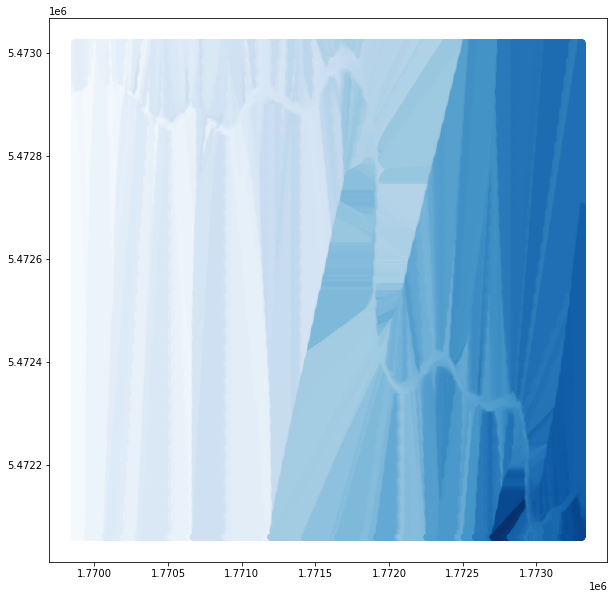

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(
    full_data[:,0],
    full_data[:,1],
    c=full_data[:,2],
    cmap="Blues"
)

plt.show()

# Another way to do interpolation

In [35]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

In [36]:
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

In [41]:
rng = np.random.default_rng()
points = rng.random((1000, 2))
values = func(points[:, 0], points[:, 1])

In [51]:
grid_y.shape

(100, 200)

In [43]:
from scipy.interpolate import griddata
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

In [53]:
grid_z0

array([[1.62654458e-08, 1.62654458e-08, 1.62654458e-08, ...,
        3.06937445e-03, 3.06937445e-03, 3.06937445e-03],
       [1.62654458e-08, 1.62654458e-08, 1.62654458e-08, ...,
        3.06937445e-03, 3.06937445e-03, 3.06937445e-03],
       [1.62654458e-08, 1.62654458e-08, 1.62654458e-08, ...,
        3.06937445e-03, 3.06937445e-03, 3.06937445e-03],
       ...,
       [8.87021472e-10, 8.87021472e-10, 8.87021472e-10, ...,
        1.12495997e-02, 1.12495997e-02, 1.12495997e-02],
       [8.87021472e-10, 6.91162023e-07, 6.91162023e-07, ...,
        1.12495997e-02, 1.12495997e-02, 1.12495997e-02],
       [6.91162023e-07, 6.91162023e-07, 6.91162023e-07, ...,
        1.12495997e-02, 1.12495997e-02, 1.12495997e-02]])